In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid
from scipy.optimize import curve_fit


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline

fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
av     = xr.open_dataset('averages_00031502.nc', decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [4]:
%%time
xh= fs.xh.values
yh = fs.yh.values
Nlayers=15
Depth=fs.depth_ocean
rho  =os.Layer
rho= rho.Layer.rename({'Layer': 'zl'})

h  = av['h'].mean('time').fillna(0.)
#Remove thin layers
h_masked = h.where(h >.1) 
#Create mask for multiplying rho array
mask = h_masked*0+1.
rho_3D=mask*rho

layer_pos = h_masked.cumsum(dim='zl')

CPU times: user 2.18 s, sys: 1.52 s, total: 3.69 s
Wall time: 7.56 s


In [48]:
#Now find density difference between lowest and highest filled value, 1/e of that. 
rho_diff = (rho_3D.max(axis=0)-rho_3D.min(axis=0))*1/np.e
rho_efold = rho_3D.min(axis=0)+rho_diff;
#nearest_layer = rho_3D.sel(zl=rho_efold,method='nearest')

#Find position of the nearest layer
thermocline_pos=layer_pos.sel(zl=rho_efold,method='nearest')
#That's the thermocline depth!

In [49]:
print(h[5,50,50])
print(mask[6,50,50])
print(rho_3D[:,50,50])
print(nearest_layer[50,50])
print(thermocline_pos[50,50])

<xarray.DataArray 'h' ()>
array(0.02450544, dtype=float32)
Coordinates:
    yh       float64 -57.38
    zl       float64 1.025e+03
    xh       float64 12.62
<xarray.DataArray 'h' ()>
array(1., dtype=float32)
Coordinates:
    yh       float64 -57.38
    zl       float64 1.025e+03
    xh       float64 12.62
<xarray.DataArray (zl: 15)>
array([    nan,     nan,     nan,     nan,     nan,     nan, 1025.47,
       1026.  , 1026.48, 1026.9 , 1027.27, 1027.58, 1027.82, 1027.99,
       1028.1 ])
Coordinates:
    yh       float64 -57.38
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
    xh       float64 12.62
<xarray.DataArray ()>
array(1026.48)
Coordinates:
    yh       float64 -57.38
    zl       float64 1.026e+03
    xh       float64 12.62
<xarray.DataArray 'h' ()>
array(322.39978, dtype=float32)
Coordinates:
    yh       float64 -57.38
    zl       float64 1.026e+03
    xh       float64 12.62


In [65]:
layer_pos.zl

<xarray.DataArray 'zl' (zl: 15)>
array([1022.6 , 1022.81, 1023.2 , 1023.74, 1024.32, 1024.9 , 1025.47, 1026.  ,
       1026.48, 1026.9 , 1027.27, 1027.58, 1027.82, 1027.99, 1028.1 ])
Coordinates:
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    long_name:       Layer Target Potential Density
    units:           kg m-3
    cartesian_axis:  Z
    positive:        up

Text(0, 0.5, 'layer position')

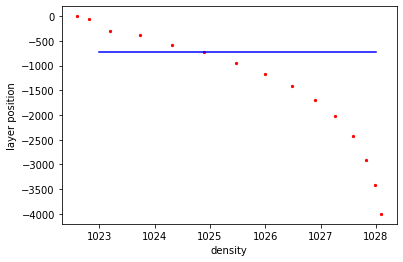

In [55]:
fig = plt.figure()
ax = fig.subplots()
#ax.scatter(rho,  -layer_pos[:,150,150],color='b',s=5)
#ax.plot([1023,1028],[-thermocline_pos[150,150],-thermocline_pos[150,150]],color='b')

ax.scatter(rho,  -layer_pos[:,200,200],color='r',s=5)
ax.plot([1023,1028],[-thermocline_pos[200,200],-thermocline_pos[200,200]],color='b')

#ax.scatter(rho,  -layer_pos[:,400,120],color='c',s=5)

#ax.plot(rho, fit_eq, color='r', alpha=0.7)
ax.set_xlabel('density')
ax.set_ylabel('layer position')

In [124]:
test = layer_pos[:,50,50]
print(test)

<xarray.DataArray 'h' (zl: 15)>
array([4.7109367e-07, 3.0936772e-06, 1.7696024e-05, 4.7604335e-05,
       4.7413947e-04, 2.4979584e-02, 9.0529674e-01, 1.4037838e+01,
       3.2242477e+02, 7.0769409e+02, 1.1716293e+03, 1.6550719e+03,
       2.5435383e+03, 3.3294966e+03, 3.9027102e+03], dtype=float32)
Coordinates:
    yh       float64 -57.38
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
    xh       float64 12.62


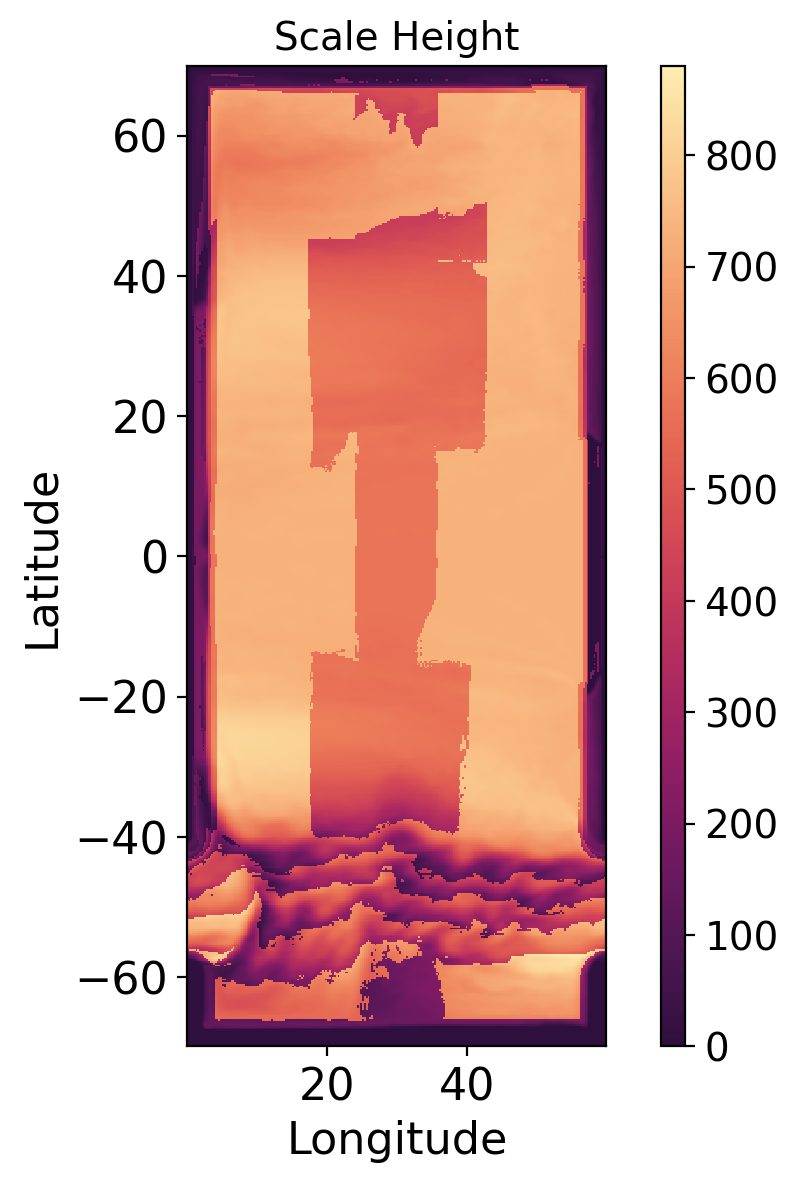

In [64]:
fig = plt.figure(figsize=(4, 7), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Scale Height',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh,yh,thermocline_pos,cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

In [151]:
np.nanmean(scale_G)

0.95554316